In [ ]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [ ]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DXG DATA PREPARATION**

In [ ]:
# Read Data
df = pd.read_csv('DXG Historical Data 1_6 Fed.csv')

In [ ]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DXG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DXG,2018-01-02,13401.400
1,DXG,2018-01-03,13371.100
2,DXG,2018-01-04,13522.400
3,DXG,2018-01-05,13159.400
4,DXG,2018-01-06,13363.575
...,...,...,...
2338,DXG,2024-05-28,16800.000
2339,DXG,2024-05-29,16850.000
2340,DXG,2024-05-30,16850.000
2341,DXG,2024-05-31,16800.000


In [ ]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [ ]:
# Sizing
size = int(len(df1))

# 9 : 1 Ratio
train_data = df1[:int(0.9 *size)]
test_data = df1[int(0.9 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 2108
Test lenght: 235


In [ ]:
# Train_data MAX Value
train_data.max()

unique_id                    DXG
ds           2023-10-10 00:00:00
y                        46750.0
dtype: object

# **TRAINING PROCESSS**

In [ ]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 200,  # 200 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [ ]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 279 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
683 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [ ]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [ ]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
235     9907.716797
236     9374.919922
237     9647.511719
238     9508.739258
239     9655.298828
240     9325.946289
241     9281.634766
242    10589.372070
243    10494.817383
244     9309.407227
245     8346.533203
246     8154.935547
247     8375.277344
248     8374.452148
249     8303.562500
250     8495.509766
251     8779.442383
252    10196.126953
253     9817.305664
254     8594.710938
255     7693.708984
256     7557.875488
257     7571.663086
258     7338.720703
259     7094.951172
260     7407.311523
261     7675.938477
262     8787.033203
263     8188.183105
264     7355.629883
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
265    6690.409180
266    6747.286133
267    6453.458008
268    6156.803711
269    5920.579102
270    6332.853516
271    6315.317383
272    6932.238281
273    6419.174805
274    5725.073242
275    5487.670898
276    5575.990234
277    5122.548828
278    4810.664062
279    4746.127930
280    

# **EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 8666.98998310062
Mean Absolute Percentage Error (MAPE): 0.47199372378609644
Mean Square Error (MSE): 79130103.11287378
Root Mean Square Error (RMSE): 8895.510278386158


# **VISUALIZATION**

In [ ]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

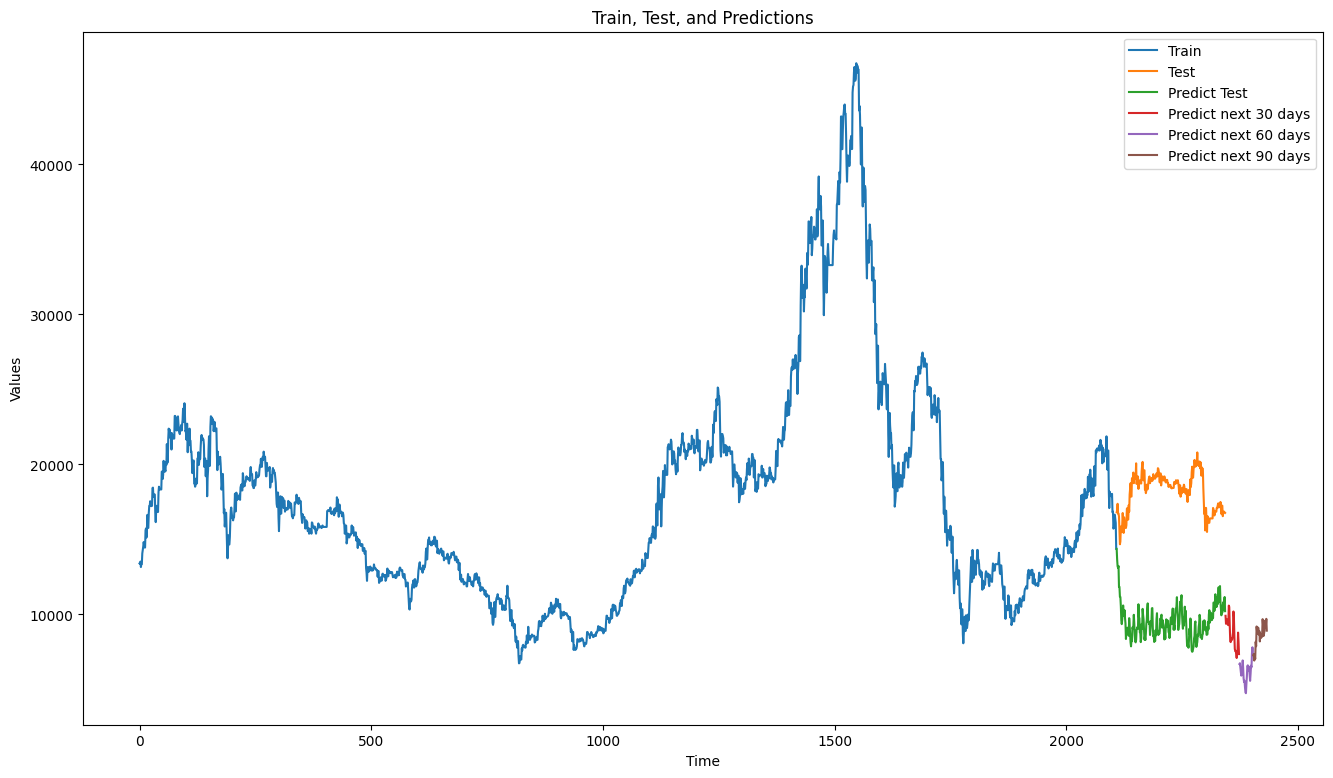

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [ ]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [ ]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [ ]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [ ]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[10062.888   9969.791   9776.151   9653.903   9633.881   9608.752
  9554.067   9457.278   9369.59    9266.764   9160.111   9050.046
  8871.62    8769.654   8738.266   8696.418   8628.766   8536.296
  8454.812   8361.647   8244.118   8104.989   7931.9893  7859.5645
  7832.268   7761.9272  7629.358   7489.6504  7353.318   7199.829 ]

Predicted Data for the next 60 days:
[6999.685  6784.8403 6566.3413 6450.0625 6378.524  6272.5664 6145.872
 6051.881  5984.596  5890.4604 5769.95   5687.343  5601.588  5600.865
 5649.2456 5700.457  5743.418  5831.752  5906.788  5992.7495 6026.8325
 6116.762  6172.28   6313.6035 6473.77   6605.76   6745.7183 6920.426
 7063.7686 7213.633 ]

Predicted Data for the next 90 days:
[7315.6133 7445.214  7575.1343 7741.6865 7901.8276 7999.0522 8130.335
 8294.302  8409.263  8470.505  8502.505  8571.181  8610.669  8668.246
 8782.794  8812.926  8838.35   8860.452  8880.622  8900.246  8920.711
 8943.404  8969.713  9001.025  9038.727 

# **RE - EVALUATION**

In [ ]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 8672.50420766844
Mean Absolute Percentage Error (MAPE): 0.4723070658746959
Mean Square Error (MSE): 78867855.84268264
Root Mean Square Error (RMSE): 8880.75761648085


# **RE - VISUALIZATION**

In [ ]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

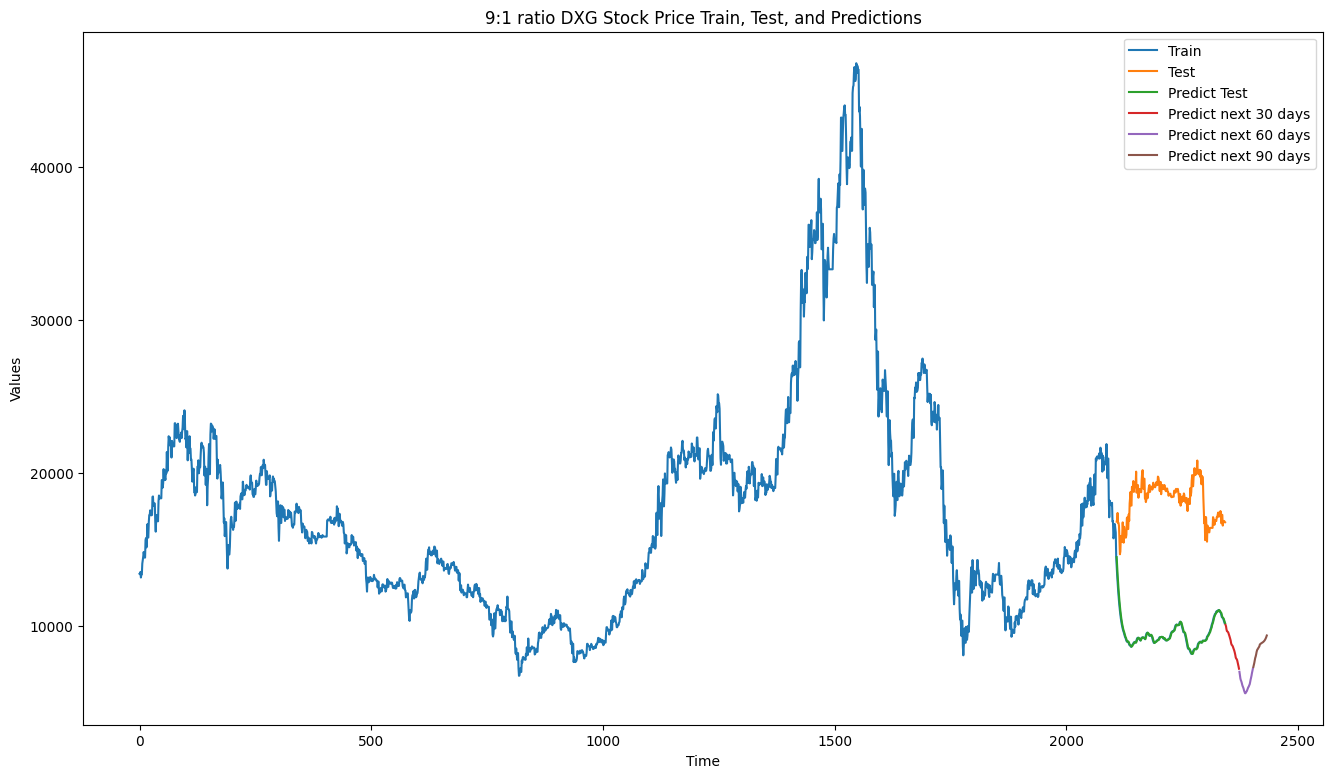

In [ ]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('9:1 ratio DXG Stock Price Train, Test, and Predictions')
plt.show()